![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FGenerate&file=Vertex+AI+Imagen+For+Image+Generation.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Generate/Vertex%20AI%20Imagen%20For%20Image%20Generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FGenerate%2FVertex%2520AI%2520Imagen%2520For%2520Image%2520Generation.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Generate/Vertex%20AI%20Imagen%20For%20Image%20Generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Generate/Vertex%20AI%20Imagen%20For%20Image%20Generation.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI Imagen For Image Generation

https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.66.0'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'imagen'

packages:

In [264]:
import os
import json
import base64, io

import matplotlib.pyplot as plt

from google.cloud import aiplatform
import vertexai.generative_models # for Gemini Models

In [14]:
aiplatform.__version__

'1.66.0'

clients:

In [15]:
vertexai.init(project = PROJECT_ID, location = REGION)

Parameters:

In [16]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [17]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Text For Examples

Vertex AI hosts many [Google models](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models) as an API.  It also host partner models and offers managed services for hosting private models as well as training models with a full suite of [MLOps capabilities](../../MLOps/readme.md).  This section uses the [Vertex AI Gemini API](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/inference) which is covered in much more depth in [this workflow](./Vertex%20AI%20Gemini%20API.ipynb).

**Task:** Generate a set of text samples to use in prompts for image generation.

In [113]:
llm = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-001")

In [114]:
response_schema = {
    'type': 'OBJECT',
    'properties': {
        'name': {'type': 'STRING'},
        'description': {'type': 'STRING'},
        'breeds': {
            'type': 'ARRAY',
            'items' : {
                'type': 'OBJECT',
                'properties': {
                    'name': {'type': 'STRING'},
                    'physical_description': {'type': 'STRING'},
                    'unique_characteristics': {'type': 'STRING'}
                }
            }
        }
    }
}

In [115]:
groups = ['sporting', 'hound', 'working', 'terrior', 'toy', 'non-sporting', 'herding']

In [120]:
responses = await asyncio.gather(*[
    llm.generate_content_async(
        [
            f'Make a list of dog breeds for the {group}.',
            'Include the following for the group: name and description.'
            'Include the follow for each breed: name, description, unique physical characteristics.'
            #'nclude breeds and varieties in the group from the 212 breeds and varieties recognized by the AKC.'
        ],
        generation_config = vertexai.generative_models.GenerationConfig(
            temperature = 0.0,
            max_output_tokens = 8192,
            response_mime_type = 'application/json',
            response_schema = response_schema
        )
    ) for group in groups
])

In [121]:
breed_data = [json.loads(response.text) for response in responses]

In [122]:
breed_data[0]['name']

'Sporting'

In [123]:
breed_data[0]['description']

'Sporting dogs are a group of dogs that were originally bred for hunting. They are known for their athleticism, intelligence, and trainability. Sporting dogs are often used in hunting birds, small game, and big game.'

In [124]:
len(breed_data[0]['breeds'])

19

In [126]:
[breed['name'] for breed in breed_data[0]['breeds']]

['Afghan Hound',
 'American Foxhound',
 'Basset Hound',
 'Beagle',
 'Bloodhound',
 'Brittany',
 'Cocker Spaniel',
 'English Cocker Spaniel',
 'English Springer Spaniel',
 'Field Spaniel',
 'German Shorthaired Pointer',
 'German Wirehaired Pointer',
 'Irish Red Setter',
 'Irish Water Spaniel',
 'Labrador Retriever',
 'Pointer',
 'Rhodesian Ridgeback',
 'Weimaraner',
 'Wirehaired Pointing Griffon']

In [135]:
breed_data[0]['breeds'][0]['name']

'Afghan Hound'

In [136]:
breed_data[0]['breeds'][0]['physical_description']

'The Afghan Hound is a tall, slender dog with a long, silky coat. They have a distinctive, proud head carriage and a long, flowing tail.'

In [137]:
breed_data[0]['breeds'][0]['unique_characteristics']

'Known for their independent nature and aloofness, Afghan Hounds are also known for their speed and agility. They are often used in sighthound racing.'

___
## Generate Images

In [199]:
from vertexai.preview.vision_models import ImageGenerationModel
from vertexai.preview.vision_models import Image
from vertexai.preview.vision_models import WatermarkVerificationModel

In [201]:
imagen = ImageGenerationModel.from_pretrained('imagen-3.0-generate-001')

---
### Single Image From Prompt

In [175]:
response = imagen.generate_images(
    prompt = ''.join([
        'Generate an photo realistic image with a black background of a dog with the following characteristics:',
        f"breed group: {breed_data[0]['name']}",
        f"breed group description: {breed_data[0]['description']}",
        f"breed name: {breed_data[0]['breeds'][0]['name']}",
        f"breed description: {breed_data[0]['breeds'][0]['physical_description']}",
        f"unqiue characteristics: {breed_data[0]['breeds'][0]['unique_characteristics']}"
    ]),
    number_of_images = 1,
    language = 'en',
    aspect_ratio = '1:1',
)

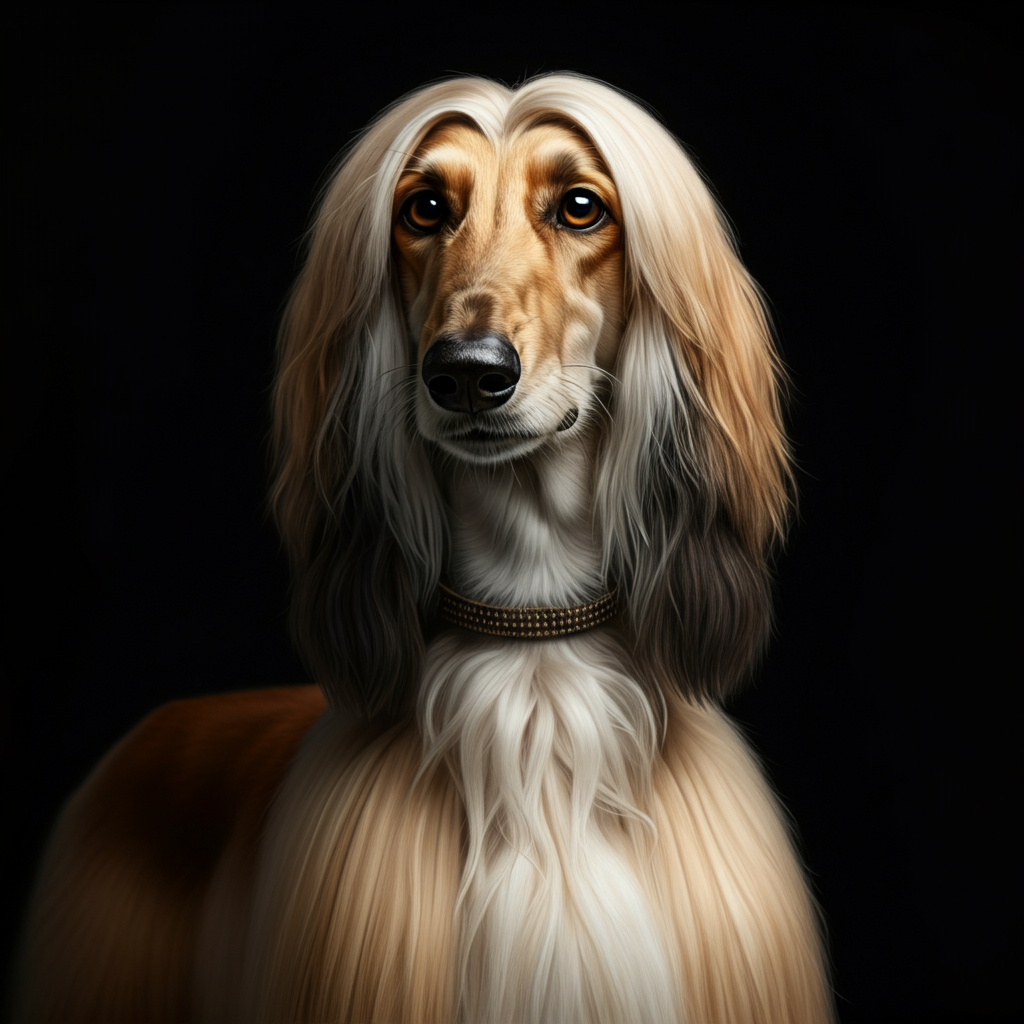

In [176]:
response[0].show()

#### Examine Response Object

In [160]:
type(response)

vertexai.preview.vision_models.ImageGenerationResponse

In [159]:
type(response.images)

list

In [161]:
type(response.images[0])

vertexai.preview.vision_models.GeneratedImage

In [166]:
type(response[0])

vertexai.preview.vision_models.GeneratedImage

In [162]:
type(response.images[0].generation_parameters)

dict

In [164]:
type(response.images[0]._pil_image)

PIL.PngImagePlugin.PngImageFile

In [178]:
type(response.images[0]._image_bytes)

bytes

---
### Multiple Images From Prompt

In [181]:
response = imagen.generate_images(
    prompt = ''.join([
        'Generate an photo realistic image with a black background of a dog with the following characteristics:',
        f"breed group: {breed_data[0]['name']}",
        f"breed group description: {breed_data[0]['description']}",
        f"breed name: {breed_data[0]['breeds'][0]['name']}",
        f"breed description: {breed_data[0]['breeds'][0]['physical_description']}",
        f"unqiue characteristics: {breed_data[0]['breeds'][0]['unique_characteristics']}"
    ]),
    number_of_images = 4,
    language = 'en',
    aspect_ratio = '1:1',
)

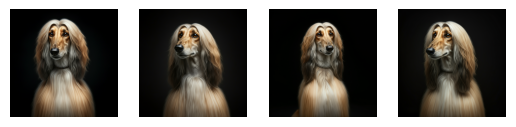

In [182]:
fix, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(response.images[i]._pil_image)
    ax[i].axis('off')
plt.show()

---
### Save Image

In [183]:
response.images[0].save(location = f"{DIR}/image_0_0.png")

In [184]:
os.listdir(DIR)

['image_0_0.png']

In [188]:
response.images[0]._pil_image.save(fp = f"{DIR}/image_0_0.jpeg", format = 'JPEG')

In [189]:
os.listdir(DIR)

['image_0_0.png', 'image_0_0.jpeg']

---
### Load Image

In [237]:
image = Image(image_bytes = response.images[0]._image_bytes) # or gcs_uri = ''
type(image)

vertexai.vision_models.Image

In [238]:
image = Image.load_from_file(location = f"{DIR}/image_0_0.png")
type(image)

vertexai.vision_models.Image

In [239]:
image = Image.load_from_file(location = f"{DIR}/image_0_0.jpeg")
type(image)

vertexai.vision_models.Image

---
### Watermark Image

In [240]:
verification_model = WatermarkVerificationModel.from_pretrained("imageverification@001")

In [241]:
verification_model.verify_image(image)

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'ACCEPT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='ACCEPT')

In [242]:
response = imagen.generate_images(
    prompt = ''.join([
        'Generate an photo realistic image with a black background of a dog with the following characteristics:',
        f"breed group: {breed_data[0]['name']}",
        f"breed group description: {breed_data[0]['description']}",
        f"breed name: {breed_data[0]['breeds'][0]['name']}",
        f"breed description: {breed_data[0]['breeds'][0]['physical_description']}",
        f"unqiue characteristics: {breed_data[0]['breeds'][0]['unique_characteristics']}"
    ]),
    number_of_images = 1,
    language = 'en',
    aspect_ratio = '1:1',
    add_watermark = False
)

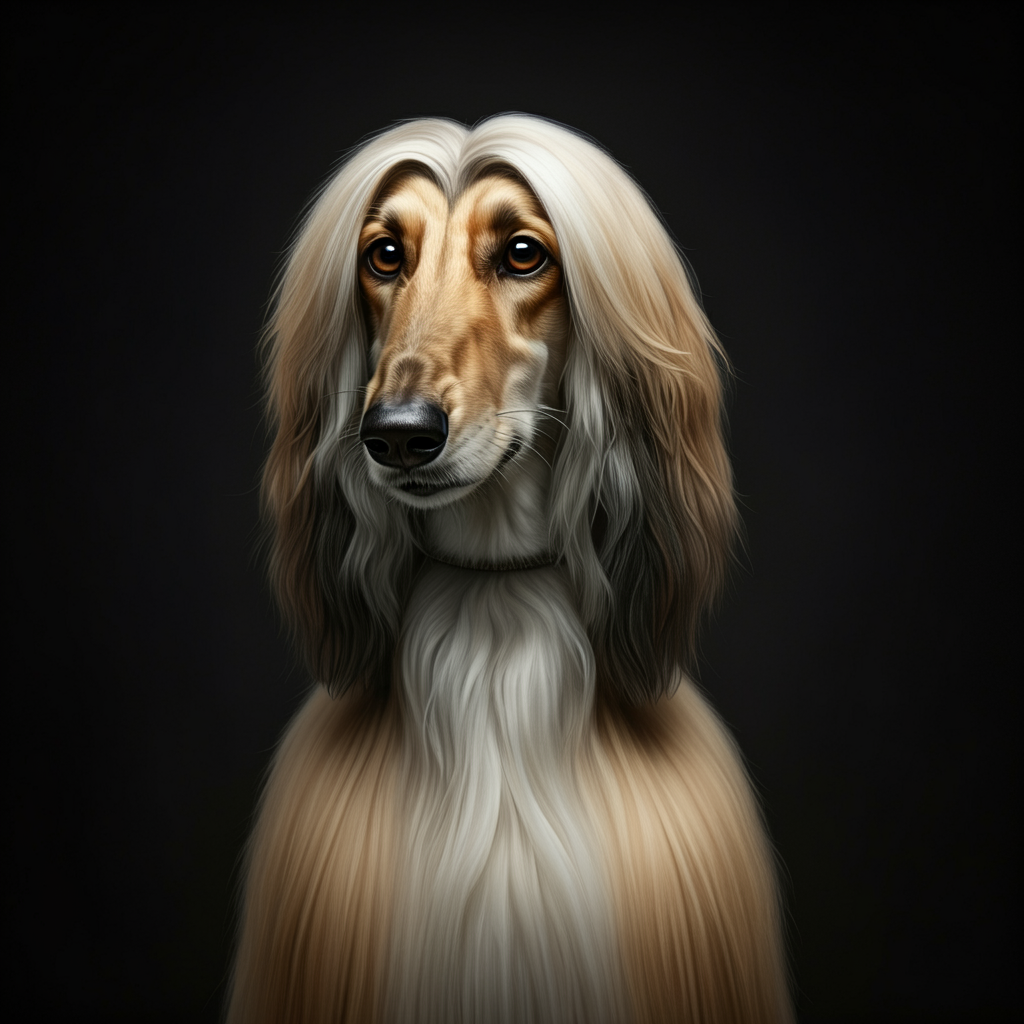

In [243]:
response.images[0].show()

In [244]:
verification_model.verify_image(response.images[0])

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'REJECT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='REJECT')

---
### Check Watermark

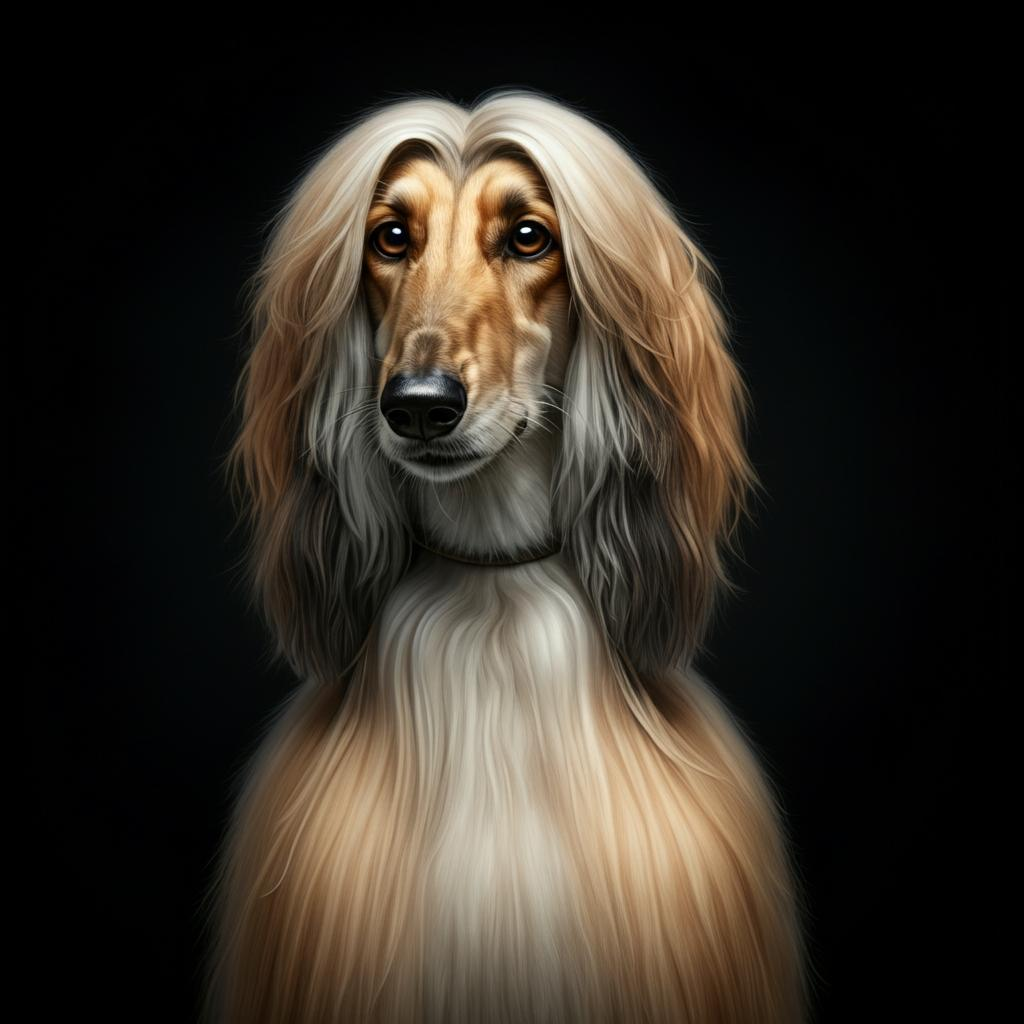

In [245]:
image.show()

In [246]:
verification_model.verify_image(image)

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'ACCEPT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='ACCEPT')

In [247]:
type(image._pil_image)

PIL.JpegImagePlugin.JpegImageFile

In [270]:
image._pil_image.size

(1024, 1024)

In [271]:
altered_image = image._pil_image.resize((100, 100))

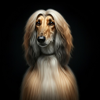

In [273]:
altered_image

In [275]:
with io.BytesIO() as output:
    altered_image.save(output, format='PNG')
    altered_image_bytes = output.getvalue()

In [276]:
altered_image_load = Image(image_bytes = altered_image_bytes)

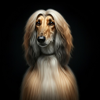

In [277]:
altered_image_load.show()

In [278]:
verification_model.verify_image(altered_image_load)

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'ACCEPT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='ACCEPT')

In [282]:
altered_image = altered_image.crop((20, 20, 80, 80))

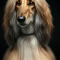

In [283]:
altered_image

In [284]:
with io.BytesIO() as output:
    altered_image.save(output, format='PNG')
    altered_image_bytes = output.getvalue()

In [285]:
altered_image_load = Image(image_bytes = altered_image_bytes)

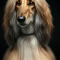

In [286]:
altered_image_load.show()

In [287]:
verification_model.verify_image(altered_image_load)

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'REJECT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='REJECT')

---
## Generate Many Images

notes on qoutas and limits here

In [294]:
for g, group in enumerate(breed_data):
    for b, breed in enumerate(group['breeds']):

        response = imagen.generate_images(
            prompt = ''.join([
                'Generate an photo realistic image with a black background of a dog with the following characteristics:',
                f"breed group: {group['name']}",
                f"breed group description: {group['description']}",
                f"breed name: {breed['name']}",
                f"breed description: {breed['physical_description']}",
                f"unqiue characteristics: {breed['unique_characteristics']}"
            ]),
            number_of_images = 1,
            language = 'en',
            aspect_ratio = '1:1',
        )
        image = response.images[0]._pil_image.resize((300, 300))
        image.save(fp = f"{DIR}/image_{g}_{b}.png", format = 'PNG')
        breed_data[g]['breeds'][b]['image'] = f'image_{g}_{b}.png'

In [296]:
os.listdir(DIR)[0:10]

['image_3_16.png',
 'image_3_7.png',
 'image_3_1.png',
 'image_0_5.png',
 'image_6_12.png',
 'image_0_15.png',
 'image_5_13.png',
 'image_1_11.png',
 'image_3_2.png',
 'image_5_7.png']

### Save Data To Directory

Create a local file of JSONL from the breed data generated here:

In [297]:
with open(f'{DIR}/breed-data.jsonl', 'w') as f:
    for group in breed_data:
        f.write(json.dumps(group)+ '\n')

In [299]:
os.listdir(DIR)[-20:]

['image_2_16.png',
 'image_2_6.png',
 'image_6_1.png',
 'image_0_13.png',
 'image_6_5.png',
 'image_0_8.png',
 'image_1_9.png',
 'breed-data.jsonl',
 'image_6_8.png',
 'image_1_6.png',
 '.ipynb_checkpoints',
 'image_0_11.png',
 'image_5_3.png',
 'image_4_5.png',
 'image_6_7.png',
 'image_5_10.png',
 'image_2_17.png',
 'image_1_1.png',
 'image_5_6.png',
 'image_1_10.png']

---
## Edit Images

In [291]:
type(response.images[0])

vertexai.preview.vision_models.GeneratedImage

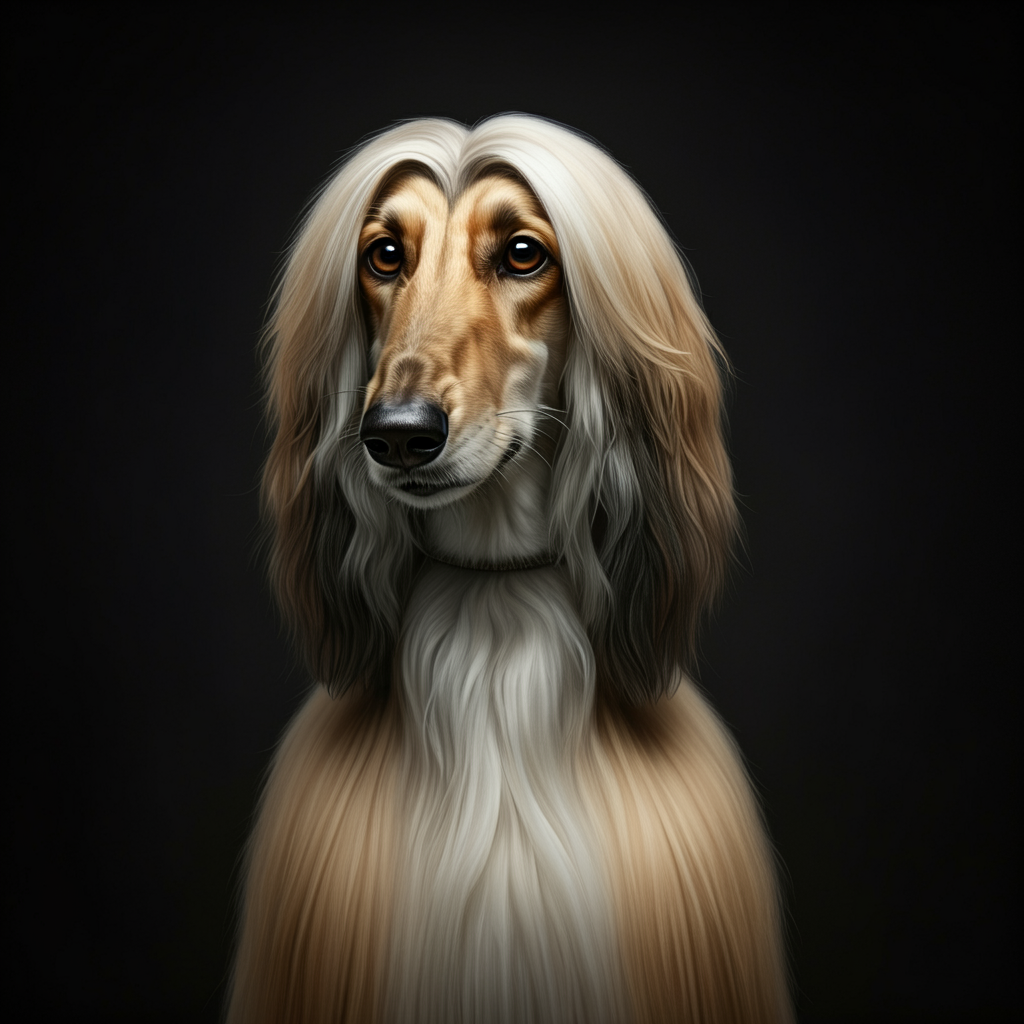

In [292]:
response.images[0].show()

In [ ]:


- edit iamge

- image captuion
- visual Q&A
- gemini Q&A
